### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a simple Rescorla-Wagner reinforcement learning model (i.e., simulations, model fitting)

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [3]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms
from pyEM import plotting
import rw_models
import joblib

In [4]:
modelID = 'RW'
# param_names = ['beta', 'lr']
param_names = ['alpha_rew', 'alpha_pun', 'beta'] # slot version
objfunc_dict = {modelID: rw_models.fit}
simul_dict   = {modelID: rw_models.simulate}

nsubjects = 50 #double check
betamin, betamax   = .75,  10
alphamin, alphamax = .05, .95

params = np.ones((nsubjects, 2))
for simS in tqdm(range(nsubjects)):
    # For beta, we will sample from a normal distribution and then transform
    # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
    params[simS, 0] = norm.rvs(0, scale=1)
    while params[simS, 0] > betamax or params[simS, 0] < betamin:
        params[simS, 0] = norm2beta(norm.rvs(0, scale=1))

    # For alpha, we will sample from a beta distribution and then transform
    params[simS, 1] = beta.rvs(1.1, 1.1)
    while params[simS, 1] > alphamax or params[simS, 1] < alphamin:
        params[simS, 1] = beta.rvs(1.1, 1.1)

100%|██████████| 50/50 [00:00<00:00, 8837.18it/s]


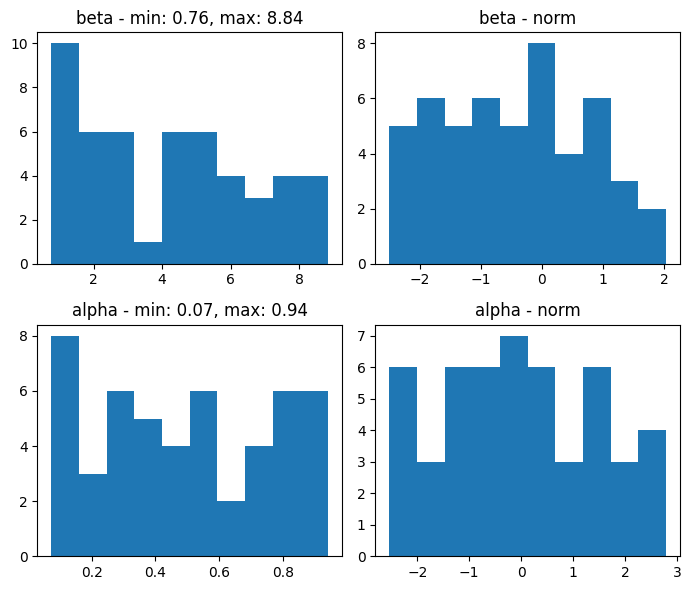

In [5]:
# plot 2 x 2
plt.figure(figsize=(7, 6))
plt.subplot(221)
plt.hist(params[:,0]);
plt.title(f'beta - min: {min(params[:,0]):.2f}, max: {max(params[:,0]):.2f}');

plt.subplot(222)
plt.hist(beta2norm(params[:,0]));
plt.title(f'beta - norm');

plt.subplot(223)
plt.hist(params[:,1]);
plt.title(f'alpha - min: {min(params[:,1]):.2f}, max: {max(params[:,1]):.2f}');

plt.subplot(224)
plt.hist(alpha2norm(params[:,1]));
plt.title(f'alpha - norm');

plt.tight_layout()

In [13]:
ntrials, nblocks = 24, 6
print(f'ntrials: {ntrials}, nblocks: {nblocks}')

simulfunc = simul_dict['RW']
subj_dict = simulfunc(params, nblocks=nblocks, ntrials=ntrials)

ntrials: 24, nblocks: 6


100%|██████████| 50/50 [00:00<00:00, 197.75it/s]


In [14]:
print(subj_dict.keys())

dict_keys(['params', 'ev', 'ch_prob', 'choices', 'choices_A', 'rewards', 'pe', 'choice_nll'])


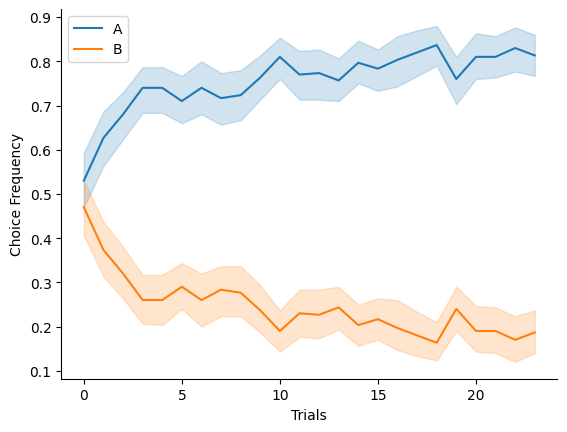

In [8]:
plotting.plot_choices(subj_dict['choices_A']) 

# Fit subject behavior data

In [45]:
# load dataframe
baseline_slot = pd.read_csv('../data/glm_slot_baseline_n235.csv')

sub_c = baseline_slot[['participant', 'block_type', 'choice', 'reward']]
sub_c

,participant,block_type,choice,reward
0,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0
1,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0
2,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1
3,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1
4,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1
...,...,...,...,...
25085,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1
25086,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1
25087,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1
25088,63d1c1b521f75a8a9f14160f,numberbar_mixed,1,0


In [47]:
# Recode reward back to outcome (-1, 0, 1)
def recode_outcome(row):
    if row['block_type'] == 'numberbar_neg' and row['reward'] == 1:
        return 0  # Negative block and reward 1 = $0
    elif row['block_type'] == 'numberbar_neg' and row['reward'] == 0:
        return -1   # Negative block and reward 0 = -$10
    elif row['block_type'] == 'numberbar_pos' and row['reward'] == 1:
        return 1   # Positive block and reward 1 = $10
    elif row['block_type'] == 'numberbar_pos' and row['reward'] == 0:
        return 0   # Positive block and reward 0 = $0
    elif row['block_type'] == 'numberbar_mixed' and row['reward'] == 1:
        return 1   # Mixed block and reward 1 = $10
    elif row['block_type'] == 'numberbar_mixed' and row['reward'] == 0:
        return -1   # Mixed block and reward 0 = -$10
    else:
        return None  # Handle any unexpected cases (optional)

# Apply the function to the DataFrame to create a new 'outcome' column
sub_c['outcome'] = sub_c.apply(recode_outcome, axis=1)
sub_c

c:\Users\fuq01\Anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,participant,block_type,choice,reward,outcome
0,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,-1
1,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,-1
2,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,0
3,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,0
4,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,0
...,...,...,...,...,...
25085,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1
25086,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1
25087,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1
25088,63d1c1b521f75a8a9f14160f,numberbar_mixed,1,0,-1


In [48]:
sub_c['reward'].unique()

array([0, 1], dtype=int64)

In [6]:
all_data = []

# Step 2: Group by subject
grouped = sub_c.groupby('participant')

# Step 3: Iterate through each group (subject)
for subject, group in grouped:
    # Step 4: Sort the group by block (if needed)
    group_sorted = group.sort_values('block_type')
    
    # Step 5: Extract choices_L and rewards
    choices_L = group_sorted['choice'].values
    outcomes = group_sorted['outcome'].values
    
    # Step 6: Check if the subject has exactly 105 trials
    if len(choices_L) == 105 and len(outcomes) == 105:
        # Step 7: Reshape choices_L and rewards into 3x35 arrays
        choices = choices_L.reshape(3, 35)
        outcomes = outcomes.reshape(3, 35)
        
        # Step 8: Append the subject data as a list of [choices_L_array, rewards_array]
        all_data.append([choices, outcomes])

In [9]:
# create a list of lists with choices and rewards for each subject
# all_data = []
# for idx, (choices, rewards) in enumerate(zip(subj_dict['choices'], subj_dict['rewards'])):
#     all_data += [[choices, rewards]]

In [7]:
modelID = 'RW'
# param_names = ['beta', 'lr']
param_names = ['alpha_rew', 'alpha_pun', 'beta'] # slot version
objfunc_dict = {modelID: rw_models.fit_slot}
nsubjects = 20 #double check

In [8]:
m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, objfunc_dict['RW'], param_names)

21085.658 (000), 15922.613 (001), 15684.999 (002), 15577.600 (003), 15523.533 (004), 15493.069 (005), 15475.019 (006), 15463.446 (007), 15456.575 (008), 15451.824 (009), 15449.051 (010), 15447.545 (011), 15446.248 (012), 15444.418 (014), 15444.299 (016), 15443.895 (017), 15443.438 (018),  -- CONVERGED!!!!!


In [17]:
## Now store all relevant outputs in modout dict and save it
save_fit = True

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
nparams = len(param_names)

# Fill in general information
modout = {}
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')
modout[modelID]['behavior'] = subj_dict  # copy behavior here

# Fill in fit information
# important for fitted parameters to convert back to parameter space
est_params = m.T.copy()
for subj_idx in range(nsubjects):
    for param_idx, param_name in enumerate(param_names):
        if 'beta' in param_name:
            est_params[subj_idx, param_idx] = norm2beta(m[param_idx, subj_idx])
        elif 'alpha_rew' in param_name: #edit conversion
            est_params[subj_idx, param_idx] = norm2alpha(m[param_idx, subj_idx])
        elif 'alpha_pun' in param_name: #added conversion
            est_params[subj_idx, param_idx] = norm2alpha(m[param_idx, subj_idx])

modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = est_params
modout[modelID]['fit']['param_names'] = param_names
modout[modelID]['fit']['inverse_hess'] = inv_h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood
modout[modelID]['fit']['NLPrior'] = NLPrior
modout[modelID]['fit']['nll'] = NPL - NLPrior
modout[modelID]['fit']['aic'] = 2*nparams + 2*modout[modelID]['fit']['nll']
modout[modelID]['fit']['bic'] = np.log(ntrials*nblocks)*nparams + 2*modout[modelID]['fit']['nll']
modout[modelID]['fit']['lme'] = []

# Make sure you know if BIC is positive or negative! and replace lme with
# bic if covariance is negative.
# Error check that BICs are in a similar range
# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['ev']          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
modout[modelID]['fit']['ch_prob']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modout[modelID]['fit']['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modout[modelID]['fit']['choices_L']   = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['outcomes']     = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['pe']          = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['negll']       = np.zeros((nsubjects,))

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
for subj_idx in range(nsubjects):
    try:
        det_inv_hessian = np.linalg.det(inv_h[:, :, subj_idx])
        hHere = np.linalg.slogdet(inv_h[:, :, subj_idx])[1]
        L = -NPL - 0.5 * np.log(1 / det_inv_hessian) + (nparams / 2) * np.log(2 * np.pi)
        goodHessian[subj_idx] = 1
    except:
        print('Hessian is not positive definite')
        try:
            hHere = np.linalg.slogdet(inv_h[:,:,subj_idx])[1]
            L = np.nan
            goodHessian[subj_idx] = 0
        except:
            print('could not calculate')
            goodHessian[subj_idx] = -1
            L = np.nan
    modout[modelID]['fit']['lme'] = L
    modout[modelID]['fit']['goodHessian'] = goodHessian

    # Get subjectwise model predictions# get info for current subject
    choices = subj_dict['choices'][subj_idx,:,:]
    rewards = subj_dict['outcomes'][subj_idx,:,:]
    
    model_fits = rw_models.fit(m[:,subj_idx], choices, rewards, prior=None, output='all') # outputs subj_dict from your fit function

    # store model fits
    modout[modelID]['fit']['ev'][subj_idx,:,:,:] = model_fits['ev']
    modout[modelID]['fit']['ch_prob'][subj_idx,:,:,:] = model_fits['ch_prob']
    modout[modelID]['fit']['choices'][subj_idx,:,:] = model_fits['choices']
    modout[modelID]['fit']['choices_L'][subj_idx,:,:] = model_fits['choices_A']
    modout[modelID]['fit']['outcomes'][subj_idx,:,:] = model_fits['rewards']
    modout[modelID]['fit']['pe'][subj_idx,:,:] = model_fits['pe']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']

# Save output
if save_fit:
    with open(f'EMfit_{modelID}.pkl', 'wb') as f:
        pickle.dump(modout, f)

# parameter visualization

In [30]:
with open('EMfit_RW.pkl', 'rb') as f:
    modout = pickle.load(f)

In [31]:
modout['RW']['fit'].keys()

dict_keys(['norm_params', 'params', 'param_names', 'inverse_hess', 'gauss.mu', 'gauss.sigma', 'gauss.cov', 'gauss.corr', 'npl', 'NLPrior', 'nll', 'aic', 'bic', 'lme', 'ev', 'ch_prob', 'choices', 'choices_A', 'rewards', 'pe', 'negll', 'goodHessian'])

In [40]:
modout['RW']['fit']['bic']

array([[ 81.92228541,  81.97671704,  82.06050871, ...,  83.109167  ,
         83.10654604,  83.10584515],
       [143.98567003, 144.53659294, 145.33091443, ..., 147.15765334,
        147.15375181, 147.15233477],
       [158.36146331, 158.48236436, 158.69589889, ..., 159.57226996,
        159.57610458, 159.57714355],
       ...,
       [160.31206003, 160.53701583, 160.84878257, ..., 162.11591526,
        162.11482541, 162.111768  ],
       [153.01623947, 153.35184293, 153.80922926, ..., 155.55133604,
        155.53924497, 155.53205747],
       [141.37895233, 141.93046995, 142.78065333, ..., 144.91306285,
        144.91492999, 144.91598356]])

In [38]:
# modout['RW']['fit']['params'] #  fitted 3 parameters output for each subjects # 225 subjects fitted (need to regroup them with ID later)
param_df = pd.DataFrame(modout['RW']['fit']['params'], columns=modout['RW']['fit']['param_names'])

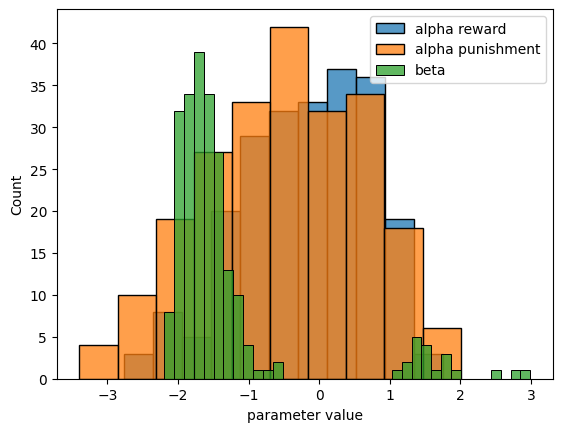

In [39]:
sns.histplot(data=param_df, x='alpha_rew', label='alpha reward')
sns.histplot(data=param_df, x='alpha_pun', label='alpha punishment')
sns.histplot(data=param_df, x='beta', label='beta')

plt.xlabel('parameter value')
plt.legend()
plt.show()

In [44]:
modout['RW']['fit']['goodHessian']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [42]:
bic_df = pd.DataFrame(modout['RW']['fit']['bic'], columns=modout['RW']['fit']['param_names'])
sns.histplot(data=param_df, x='alpha_rew', label='alpha reward')
sns.histplot(data=param_df, x='alpha_pun', label='alpha punishment')
sns.histplot(data=param_df, x='beta', label='beta')

plt.xlabel('parameter value')
plt.legend()
plt.show()

ValueError: Shape of passed values is (225, 22), indices imply (225, 3)

# Parameter recovery

In [19]:
for param_idx, param_label in enumerate(['beta', 'lr']):
    simulated_param = subj_dict['params'][:,param_idx]
    fitted_params = est_params[:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

ValueError: All arrays must be of the same length

In [ ]:
## Code if you want to open in MATLAB (leaving here for Shawn to reference so he doesn't have search for it again)

# import scipy.io
# # Save m and h to a .mat file
# data = {'m': m, 'h': inv_h}
# scipy.io.savemat('Mean_Hess_example.mat', data)

# curmu,cursigma,flagcov,covmat_out = compGauss_ms(m,inv_h,2)
# print(curmu,cursigma,flagcov,covmat_out )